# paaaaathによる統一的なファイルアクセス
> "Accessing file with unified pythonic API2"

- toc: true
- categories: [Cloud, Python, AWS, GCP]

## はじめに

[以前の記事](https://lab.ar90n.net/cloud/python/aws/gcp/2020/10/21/accessing-file-with-unified-pythonic-api.html)で，smart_openによって統一的にファイルアクセスが可能であることを紹介しました．
しかしながら，`//`を適切に扱うことができないため，URLを扱うには問題がありました．
そこで，この問題を解決しsmart_openをラップした[paaaaath](https://pypi.org/project/paaaaath/)を作成しました．

## やったこと

* paaaaathの導入
* paaaaathによるクラウドストレージ上のファイルを操作

## paaaaathについて
paaaaathはローカルマシン上のファイルパスのみでは無く，http, s3, gcsといったプロトコルのURLもpathlib.Pathと同様に取り扱うことができます．ファイルの読み書きはsmart_openに処理を委譲することで実現します．また，s3, gcsについては，mkdir, iterdirs, exitsといった処理にも対応しています．サポートしている機能の詳細については，[リポジトリ](https://github.com/ar90n/paaaaath)を確認してくさい．

以下にpipを用いたpaaaaathの導入方法を示します．ここでは，extrasとして`all`を指定しました．ほかにも，`http`, `gcs`,`s3` が指定可能です．`all`はこれら全てを指定することと同義です．

```bash
$ pip install paaaaath[all]
```

## クラウドストレージ，Webからファイルを読み込む
smart_openによる[サンプル](https://lab.ar90n.net/cloud/python/aws/gcp/2020/10/21/accessing-file-with-unified-pythonic-api.html#%E3%82%AF%E3%83%A9%E3%82%A6%E3%83%89%E3%82%B9%E3%83%88%E3%83%AC%E3%83%BC%E3%82%B8%EF%BC%8CWeb%E3%81%8B%E3%82%89%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%82%92%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%82%80)をpaaaaathを用いて書き直しました．Pathlikeオブジェクトとして取り扱うことができるので，全体的にシンプルになっていることが確認できると思います．こちらも，事前に適切な認証情報を設定しておく必要があります．

In [8]:
#hide
#hide_input
!pip install paaaaath[all]

In [4]:
#hide
#hide_input
!wget -P /tmp/ "https://s3-us-west-2.amazonaws.com/landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_BQA.TIF"

--2021-06-05 18:02:12--  https://s3-us-west-2.amazonaws.com/landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_BQA.TIF
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.183.72
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.183.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3612664 (3.4M) [image/tiff]
Saving to: ‘/tmp/LC80030172015001LGN00_BQA.TIF’

LC80030172015001LGN 100%[===================>]   3.44M  3.42MB/s    in 1.0s    

2021-06-05 18:02:14 (3.42 MB/s) - ‘/tmp/LC80030172015001LGN00_BQA.TIF’ saved [3612664/3612664]



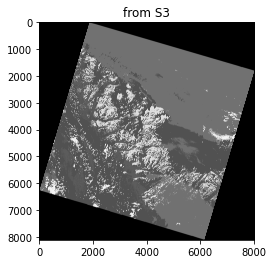

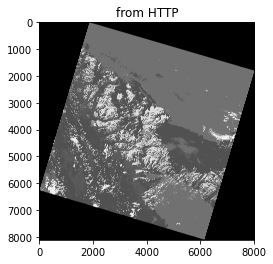

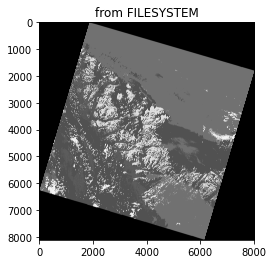

In [5]:
from paaaaath import Path
import matplotlib.pyplot as plt
import imageio

sources = {
    "S3": "s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_BQA.TIF",
    "HTTP":  "https://s3-us-west-2.amazonaws.com/landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_BQA.TIF",
    "FILESYSTEM": "/tmp/LC80030172015001LGN00_BQA.TIF"
}

for protocol, url in sources.items():
    img = imageio.imread(Path(url).read_bytes())
    plt.figure()
    plt.title(f"from {protocol}")
    plt.imshow(img, cmap='gray')

## クラウドストレージ上のファイルを操作する
paaaaathを用いてクラウドストレージ上のファイルを読み書きする例を以下に示します．

In [6]:
sample_path = Path("s3://paaaaath-examples/sample.txt")
sample_path.write_text("paaaaath example")
assert sample_path.read_text() == "paaaaath example"

また，paaaaathはPathlikeオブジェクトを提供します．そのため，単純なファイルの読み書きだけでは無く，より多くの機能を提供することが可能です．以下に，iterdirを用いてクラウドストレージ上のファイル一覧を取得する例を示します．

In [7]:
paths = list(Path(sources["S3"]).parent.iterdir())
assert paths[0].exists()
paths      

[S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B1.TIF'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B1.TIF.ovr'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B10.TIF'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B10.TIF.ovr'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B11.TIF'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B11.TIF.ovr'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B2.TIF'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B2.TIF.ovr'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B3.TIF'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030172015001LGN00_B3.TIF.ovr'),
 S3Path('s3://landsat-pds/L8/003/017/LC80030172015001LGN00/LC80030

## 参考
* [smart_open](https://github.com/RaRe-Technologies/smart_open)